# Recurrent Neural Network using Long-Short Term Memory

This notebook will train a **Recurrent Neural Network**, the type of Neural Network that has worked best for text classification. **Long - Short term memory** technique will also be used, as it has given great results recently when combined with these Networks. 

**RNN** have the characteristic that, in order to predict, they use not only the input data necessary in every ML algorith, but *also the prediction they made in the last iteration*. That is why they are called **Recurrent**. **LSTM** is a technique that uses *Memory*: The neural net is able to remember the values it has seen previously in order to affect the prediction. So for example *good* word may be interpreted different when it is with *very good* or with *not good*. This is very useful for our sentiment analysis, and this is the reason why we decided to include it as part of our network. We will create a really simple Neural Net that will have:

* One **Embedding layer**, which is used to convert our integer inputs (words) to vectors that are then given to the network.
* One **LSTM** recurrent layer, the main layer of the network that will used the previously explained techniques.
* One **Dense** layer, that will be used to convert the output from the LSTM network to a *probability* vector of length 3, as we have 3 categories to predict. We have tried different **activation functions** for this layer, such as *softmax*, *tanh* or *sigmoid*. These functions are used to convert any number into a number that is between 0 and 1.

In order to implement the previously explained techniques, we will use the **KERAS library in python**, which contains a lot of functions and classes to work with neural nets, and will help us a lot to simplify our work. We will also use the preprocessing library in this module in order to tokenize the words in the tweets.

## Import all the necessary libraries

In [1]:
#Install the package using pip
!pip install --upgrade -q gspread
!pip install keras

In [2]:
%matplotlib inline
from collections import Counter
import datetime
import itertools
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import gspread
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from google.colab import auth
from oauth2client.client import GoogleCredentials

Using TensorFlow backend.


We download the spanish stopwords that are included in the nltk text processing library in order to remove them from our vocabulary

In [3]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

my_stop_words = stopwords.words('spanish')  

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Downloading data from a spreadsheet into Python as a Pandas DataFrame

In [0]:
#Authenticate and create the interface to sheets
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [5]:
# Open tweets_public spreadsheet
sh = gc.open_by_key('1FUVYSMdgKEvGR5bxHF-Qi7X58cSWqDp8KEJ154o1tHc') #spanish airlines
#sh = gc.open_by_key('1iX7uNLzg8zcEen0DC9gpeza-SmfU6jHHAAhg0_CtoUQ') #american airlines
wsh = sh.worksheet("tweets_public")

# get_all_values gives a list of rows
rows = wsh.get_all_values()

# Convert to a DataFrame
df=pd.DataFrame.from_records(rows)

df.columns = df.iloc[0]
df.drop(0, inplace = True)
df.index = df.tweet_id
df.drop('tweet_id', inplace = True, axis = 1)

print('shape: {}'.format(df.shape))

shape: (7867, 9)


## Functions

##### Get training and testing data

In [0]:
def remove_links(text):
    'A function that will remove every http(s):// link in the text, as well as all the @'
    s = re.sub(r"http\S+", "", text)
    s = re.sub(r'@', '', s)
    return s

re_prep = re.compile(r'[^\u263a-\U0001f645]')

# We no longer use this function, as the tokenizer from Keras can grab emojis on it's own.
def capture_emojis(s1):
    'A function to capture the emojis present inside the text column'
    return re_prep.sub('', s1)

In [0]:
def obtain_data_representation(df, given_bow = None, show_modelwords = False, max_feat = 2000, stop_w = my_stop_words, lower = True, return_bow = True):
    'A function to obtain a matrix with the data representation necessary to train a model. It has several params:'
    
    # 1 - df -> Df with the data to convert
    # 2 - given_bow -> If we are dealing with the test dataset, we want the number of extracted features to match the ones expected by the model
    #                  For that reason, we give the option to the user to give a bow to be used when transforming our data.
    # 3 - show_modelwords -> If true, show the words that are included in the BoW passed to the ML algorithm to be trained.
    # 4 - max_feat -> Maximum number of words allowed for the neural net.
    # 5 - stop_w -> Vector of stop words to give to the BoW. Default = nltk stopwords for the spanish language
    # 6 - lower -> Boolean. If true, convert the text to lowercase. Default = True
    # 7 - return_bow -> If true (default), return the bow that has been used to transform the data
    
    # Fit the Tokenizer that we will use to transform the data that will be given to the NN (if no bow has been given)
    if given_bow == None:
        try:
            bow = Tokenizer(num_words = max_feat, split = ' ', lower = True)
            bow.fit_on_texts(df['text'])
            aux = bow.word_docs.copy()
            for i in aux:
                if i in my_stop_words:
                    bow.word_docs.pop(i)

        except Exception as e:
            print(e)
            return {}
    # Use the bow that is given if any.
    else:
        bow = given_bow
    
    # We will include a complete matrix of sentences.
    X = bow.texts_to_sequences(df['text'].values)
    X = pad_sequences(X)

    # Before returning the processed data, we will give the option to print word values in our tokenizer.
    if show_modelwords:
        print ('Words for the model are: ', bow.word_docs)
        
    # Grab the objective variable as a categorical variable. 3 column, one for each value in the column with 1 if that is the value for 
    # that row, and 0 if not.
    try:
        y = pd.get_dummies(df['airline_sentiment']).values
    except:
        # It might be the submision file, where we don't have target values
        y = None

        
    if return_bow:
        return {
            'feat' : X,
            'obj': y,
            'bow' : bow
           }
    
    return {
            'feat' : X,
            'obj': y
           }

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

The following functions are the ones we have used to create the model and format the predictions. Regarding the formatting of the predictions, note that **the model returns, for each possible category, a probability that a given input belongs to that category**. Therefore, we have to convert those probabilities (a number_inputs x 3 matrix) to a vector of predictions. In order to do that, we'll grab the category for which the probability is higher as the final prediction.

Regarding the model definition, we have created a function that lets us easily change all tuneable parameters of the model. In that way it is easier to check how variations in such parameters affect the accuracy of the prediction. We defined the function in such way that allows us, tweaking the parameters, to train a model and test it, to train it with full data, to print de confusion matrix...

In [0]:
def format_predictions(preds):
    'A function that given the output prediction from our RNN will convert it to the type of vector prediction we expect as output'
    res = []
    for elem in preds:
        if(np.argmax(elem) == 0):
            res.append("negative")
        elif (np.argmax(elem) == 1):
            res.append('neutral')
        elif (np.argmax(elem) == 2):
            res.append('positive')
    return res

In [0]:
def compose_LSTM(X, y, embed_dim = 256, lstm_out = 196, max_feat = 2000, print_model = True, batch_size = 32, 
                 split = 0.25, epochs = 10, activation = 'softmax', print_cnf = True, test = True):
    'A function to define a model, its lstm layer and train it with some given data'
    
    # 1 - X -> A matrix of converted input rows of tweets with the TOKENIZER object.
    # 2 - y -> The objective variable, in categorical mode (one column for each category, with 1 in the position of the corresponding label).
    # 3 - embed dim -> Dimension for each output vector of the embedding layer of the Neural Net.
    # 4 - lstm_out -> Dimensionality of the output space from the LSTM Layer.
    # 5 - max_feat -> Maximum number of features allowed for the embedding layer (that is, dimension of the input for that layer).
    # 6 - print_model -> Wether to print a summary of the network or not.
    # 7 - batch_size -> Batch size of inputs to use when fitting the Net.
    # 8 - split -> Split to use when splitting into training and testing data.
    # 9 - epochs -> Number of epochs ("steps") to use when training the Net.
    # 10 - activation -> Element-wise activation function to use. The activation function should grab any value and return a value between [0,1]. Options are:
    #       - softmax
    #       - elu
    #       - selu
    #       - softplus
    #       - softsign
    #       - relu
    #       - tanh
    #       - sigmoid
    #       - hard_sigmoid
    #       - linear
    # 11 - print_cnf -> Wether to print the confusion matrix generated by the predictions of the Net or not (default = True)
    # 12 - test -> Wether to test the model or not. If False, the model will be trained with the full data provided.
    
    def train_RNN(model, x = X, y = y, batch_size = batch_size, split_ = split, epochs = epochs, print_ = print_cnf, test_ = test):
        'A function to train a model given the data to be trained with'
        
        # Split if we want to test the model
        if test_:
            x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = split_)
        
            print('Training model with batch_size = {0}, epoch = {1}'.format(batch_size, epochs))
            model.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, verbose = 2)
        
            score,acc = model.evaluate(x_test, y_test, verbose = 2, batch_size = batch_size)
            print("score: %.2f" % (score))
            print("acc: %.2f" % (acc))
            
            # Print confusion matrix if specified
            if print_:
                preds = model.predict(x_test, batch_size = 1, verbose = 2)
                preds_final = format_predictions(preds)
                # We have the convert the test values to vector of predictions as well because we have it as a pd.categorical.
                y_fin = format_predictions(y_test)

                # Calculate confusion_matrix
                cnf = confusion_matrix(y_fin,preds_final)
                plot_confusion_matrix(cnf, classes=['negative', 'neutral', 'positive'])
        
        # Don't if we just want to train it with full data (for submission)
        else:
            model.fit(X,y, epochs = epochs, batch_size=batch_size, verbose = 2 )
        
        return model

    # Define our model. 3 layers -> Embedding (First), LSTM (Second) and Dense (Third)
    model = Sequential()
    model.add(Embedding(max_feat, embed_dim ,input_length = X.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    if print_model:
        print(model.summary())
        
    model = train_RNN(model, X, y)
    
    return model

## Preprocess data

In [11]:
# Read the data and see how it looks like. Treat it a little bit to keep what is interesting for us

df.head()

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,
942743012337123328,positive,FALSE,0,0,"""Los pilotos de Ryanair desconvocan la huelga ...",,Mon Dec 18 13:07:04 +0000 2017,,Dublin
926857871916183553,positive,TRUE,0,0,"@Iberia @lavecinarubia Si ,por favor las decla...",,Sat Nov 04 17:05:11 +0000 2017,,
936979305720090626,neutral,TRUE,0,0,@Iberia Me dirías por favor que costo tiene?,,Sat Dec 02 15:24:09 +0000 2017,,
943983853802328064,negative,TRUE,0,0,"@SupermanlopezN @Iberia @giroditalia Champion,...",,Thu Dec 21 23:17:43 +0000 2017,,Central Time (US & Canada)
938207464457211904,negative,TRUE,0,0,@SrtaFarrellDM @KLM @Iberia Eso de avianca es ...,,Wed Dec 06 00:44:25 +0000 2017,,Eastern Time (US & Canada)


Let's explore the data to see what can we do with it and what columns may be useful for us. For the moment, the idea is to just use the text of the tweet to feed into our neural net, but if we find that some other column might help the predictions, we can use it as well. 

In [12]:
# Check the amount of data that we have:
print('The size of the training dataset is: (%i, %i)' % df.shape)

# Check the number of null values in the dataset:
print('The number of NULL values per column name are: ')
print(df.isnull().sum())


print ('The number of positive, negative and neutral valorations in the training dataset are: ')
print(df.airline_sentiment.value_counts())

The size of the training dataset is: (7867, 9)
The number of NULL values per column name are: 
0
airline_sentiment    0
is_reply             0
reply_count          0
retweet_count        0
text                 0
tweet_coord          0
tweet_created        0
tweet_location       0
user_timezone        0
dtype: int64
The number of positive, negative and neutral valorations in the training dataset are: 
negative    3788
neutral     2555
positive    1524
Name: airline_sentiment, dtype: int64


We can see that we have an slightly unbalanced dataset towards **Negative** sentiments. Let's analize a little beet further the rest of the columns

In [13]:
print('REPLY_COUNT')
print(df.reply_count.value_counts())

print('\n')

print('RETWEET_COUNT')
print(df.retweet_count.value_counts())

print('\n')

print('TWEET_LOCATION')
print('Number of null values: ', (df.tweet_location == '').sum())

print('\n')

print('USER_TIMEZONE')
print('Number of null values: ', (df.user_timezone == '').sum())

REPLY_COUNT
0    7867
Name: reply_count, dtype: int64


RETWEET_COUNT
0    7867
Name: retweet_count, dtype: int64


TWEET_LOCATION
Number of null values:  7428


USER_TIMEZONE
Number of null values:  2748


We can see that these 4 columns won't be of much use for our model, but for different reasons:

* Both *is_reply* and *retweet_count* have always the same value: 0. This means that they won't make any difference in the prediction, as all negative, positive and neutral sentiments have the same value for these columns.

* *tweet_location* could be useful, but the problem here is that almost all the values in the column are NULL (**94,4% of the values are null**)

* *user_timezone* might be useful, and could be used as a replace for the location of the user but it also has a lot of null values and will not be used.


Now, we are going to define a new dataset that will be the one that will be used for training our RNN. It will only contain the sentiment and the text of the tweet.

In [0]:
df1 = df[['airline_sentiment', 'text']]

## Deep Learning Model: Training and Predicting data

## Sentiment Analyisis

The **input (training) data** will now be pre-processed by using the function **obtain_data_representation** defined above. We will use the **TOKENIZER** that is defined in the Keras documentation for deep learning in order to transform the *text of the tweet* text column into a vector of numeric features. Other features will be ignored for the moment, as we cannot observe a significant diffrerence between the different values of the objective variables for the numerical features selected (this exploratory analysis has been performed in other notebooks with time-related features such as day of the week, day of the month,... We have concluded that these features are not important for our model since there is not a clear difference for the value of these features between groups). 

Our data will be stored under the **Tokenizer class** **text_to_sequences()**.

In [15]:
df1['text'] = df1.apply(lambda x: remove_links(x.text), axis = 1)

dataset = obtain_data_representation(df1, return_bow = True)#, show_modelwords= True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


##### Deep Learning. We'll compose the LSMT network

Training model with batch_size = 32, epoch = 10
Epoch 1/10
 - 15s - loss: 0.9487 - acc: 0.5405
Epoch 2/10
 - 14s - loss: 0.8221 - acc: 0.6186
Epoch 3/10
 - 15s - loss: 0.7343 - acc: 0.6729
Epoch 4/10
 - 15s - loss: 0.6619 - acc: 0.7092
Epoch 5/10
 - 15s - loss: 0.5994 - acc: 0.7366
Epoch 6/10
 - 15s - loss: 0.5430 - acc: 0.7617
Epoch 7/10
 - 15s - loss: 0.4892 - acc: 0.7880
Epoch 8/10
 - 15s - loss: 0.4553 - acc: 0.8007
Epoch 9/10
 - 15s - loss: 0.4018 - acc: 0.8229
Epoch 10/10
 - 15s - loss: 0.3828 - acc: 0.8293
score: 1.52
acc: 0.55
[[0.63066955 0.29049676 0.07883369]
 [0.29268293 0.56554878 0.14176829]
 [0.23116883 0.45454545 0.31428571]]


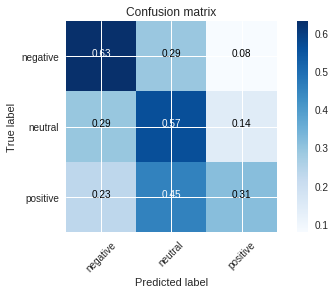

In [21]:
# We'll try with a softmax function, a sigmoid and a tanh as activations. Let's see if there are any differences in accuracy.

# Sigmoid
model_sig = compose_LSTM(dataset['feat'], dataset['obj'], activation = 'sigmoid', epochs = 10, test = True, print_cnf = True, print_model = False)

Training model with batch_size = 32, epoch = 10
Epoch 1/10
 - 15s - loss: 0.9377 - acc: 0.5442
Epoch 2/10
 - 15s - loss: 0.8124 - acc: 0.6303
Epoch 3/10
 - 15s - loss: 0.7358 - acc: 0.6653
Epoch 4/10
 - 14s - loss: 0.6621 - acc: 0.7061
Epoch 5/10
 - 14s - loss: 0.6047 - acc: 0.7285
Epoch 6/10
 - 14s - loss: 0.5406 - acc: 0.7586
Epoch 7/10
 - 15s - loss: 0.4990 - acc: 0.7847
Epoch 8/10
 - 15s - loss: 0.4524 - acc: 0.8000
Epoch 9/10
 - 14s - loss: 0.4173 - acc: 0.8244
Epoch 10/10
 - 14s - loss: 0.3886 - acc: 0.8285
score: 1.53
acc: 0.56
[[0.65882353 0.26524064 0.07593583]
 [0.29984544 0.52550232 0.17465224]
 [0.22077922 0.42337662 0.35584416]]


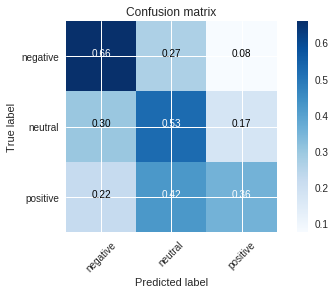

In [17]:
# Softmax
model_soft = compose_LSTM(dataset['feat'], dataset['obj'], activation = 'softmax', epochs = 10, test = True, print_cnf = True, print_model = False)

Training model with batch_size = 32, epoch = 10
Epoch 1/10
 - 17s - loss: 0.9438 - acc: 0.5420
Epoch 2/10
 - 16s - loss: 0.8130 - acc: 0.6290
Epoch 3/10
 - 15s - loss: 0.7273 - acc: 0.6771
Epoch 4/10
 - 15s - loss: 0.6615 - acc: 0.7022
Epoch 5/10
 - 15s - loss: 0.5949 - acc: 0.7412
Epoch 6/10
 - 15s - loss: 0.5444 - acc: 0.7614
Epoch 7/10
 - 15s - loss: 0.5042 - acc: 0.7815
Epoch 8/10
 - 15s - loss: 0.4635 - acc: 0.8017
Epoch 9/10
 - 15s - loss: 0.4278 - acc: 0.8127
Epoch 10/10
 - 15s - loss: 0.3962 - acc: 0.8264
score: 1.38
acc: 0.56
[[0.72804233 0.20846561 0.06349206]
 [0.39619651 0.43898574 0.16481775]
 [0.26342711 0.40664962 0.32992327]]


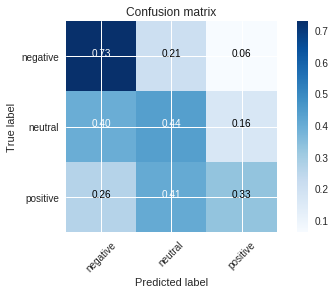

In [28]:
# TANH
model_tanh = compose_LSTM(dataset['feat'], dataset['obj'], activation = 'tanh', epochs = 10, test = True, print_cnf = True, print_model = False)

So it seems the accuracy is not varying much depending on the activarion function used. Therefore, we will use the default one, **softmax**, as activation function for the Dense layer of the model. Another option could be, as we have trained 3 models now, to use as output the category that has been predicted more times between the models, for each input value. We will use the predictions both for the **softmax** model and for the **class predicted more times** approach.

## Get output

We read test data from the drive folder (the one we will be uploading to Kaggle platform).

In [29]:
!pip install pydrive
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1cdoOwwh5HEuPTwOiKkASvLHw1kGf9VY-'}) # replace the id with id of file you want to access
downloaded.GetContentFile('tweets_submission_spanish.csv')  

df_submission = pd.read_csv('tweets_submission_spanish.csv', index_col = 'tweet_id')
df_submission.head(1)

    100% |████████████████████████████████| 993kB 17.6MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,
942273491440631808,True,0,0,@Iberia Está clara vuestra política de rascar ...,NaN,Sun Dec 17 06:01:21 +0000 2017,NaN,NaN


In [30]:
import datetime
from google.colab import files

def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y")
    filename = 'submission_' + date + '.csv'
    
    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)
    files.download(filename)
    
    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')

    
# We use df_submision as test, otherwise it would split df in train/test. As we want the dataset to have exactly the same amount of features as 
# the values used to train the model, we will use the BoW that was calculated when training the model to transform the test data
dataset_submission = obtain_data_representation(df_submission, given_bow = dataset['bow'])
print ('The shape of the testing dataset is: (%i, %i)' % (dataset_submission['feat'].shape), '\n')

The shape of the testing dataset is: (1967, 28) 



Now we are going to create 3 models using the 3 activation functions that were used before. We train them again because now we won't split in training and testing data our training dataset. We want to **train our models with as much data as possible**. With these full trained models, we will predict over the testing dataset and upload it to the Kaggle platform.

In [31]:
model_sig = compose_LSTM(dataset['feat'], dataset['obj'], activation = 'sigmoid', test = False, epochs = 10, print_model = False)
model_soft = compose_LSTM(dataset['feat'], dataset['obj'], activation = 'softmax', epochs = 10, test = False,  print_model = False)
model_tanh = compose_LSTM(dataset['feat'], dataset['obj'], activation = 'tanh', epochs = 10, test = False, print_model = False)


predictions_sig = model_sig.predict(dataset_submission['feat'], batch_size=1,verbose = 2)
predictions_soft = model_soft.predict(dataset_submission['feat'], batch_size=1,verbose = 2)
predictions_tan = model_tanh.predict(dataset_submission['feat'], batch_size=1,verbose = 2)


predictions_final_sig = format_predictions(predictions_sig)
predictions_final_soft = format_predictions(predictions_soft)
predictions_final_tan = format_predictions(predictions_tan)

Epoch 1/10
 - 22s - loss: 0.9333 - acc: 0.5494
Epoch 2/10
 - 21s - loss: 0.8120 - acc: 0.6255
Epoch 3/10
 - 21s - loss: 0.7388 - acc: 0.6648
Epoch 4/10
 - 21s - loss: 0.6746 - acc: 0.7000
Epoch 5/10
 - 21s - loss: 0.6249 - acc: 0.7243
Epoch 6/10
 - 21s - loss: 0.5796 - acc: 0.7425
Epoch 7/10
 - 21s - loss: 0.5398 - acc: 0.7613
Epoch 8/10
 - 21s - loss: 0.4971 - acc: 0.7755
Epoch 9/10
 - 20s - loss: 0.4556 - acc: 0.7942
Epoch 10/10
 - 20s - loss: 0.4284 - acc: 0.8072
Epoch 1/10
 - 22s - loss: 0.9296 - acc: 0.5504
Epoch 2/10
 - 21s - loss: 0.8034 - acc: 0.6318
Epoch 3/10
 - 21s - loss: 0.7292 - acc: 0.6742
Epoch 4/10
 - 21s - loss: 0.6765 - acc: 0.6990
Epoch 5/10
 - 21s - loss: 0.6254 - acc: 0.7206
Epoch 6/10
 - 21s - loss: 0.5800 - acc: 0.7440
Epoch 7/10
 - 20s - loss: 0.5311 - acc: 0.7632
Epoch 8/10
 - 20s - loss: 0.4961 - acc: 0.7816
Epoch 9/10
 - 20s - loss: 0.4575 - acc: 0.8040
Epoch 10/10
 - 20s - loss: 0.4281 - acc: 0.8119
Epoch 1/10
 - 22s - loss: 0.9339 - acc: 0.5579
Epoch 2/10


In [51]:
create_submit_file(df_submission, predictions_final_soft)

Submission file created: submission_05_31_2018.csv
Upload it to Kaggle InClass


Now we are going to follow the approach of calculating the prediction that has been obtained for more models.

In [32]:
import operator

def ponderate_results(row):
    d = {'negative' : 0, 'neutral' : 0, 'positive' : 0}
    for elem in row:
        d[elem] += 1
    return max(d.items(), key=operator.itemgetter(1))[0]

In [33]:
results = pd.DataFrame()
results['preds_tan'] = predictions_final_tan
results['preds_sig'] = predictions_final_sig
results['preds_soft'] = predictions_final_soft
results['ponderated_result'] = results.apply(lambda row: ponderate_results(row), axis = 1)

results.head()

,preds_tan,preds_sig,preds_soft,ponderated_result
0,negative,negative,negative,negative
1,neutral,neutral,neutral,neutral
2,negative,negative,negative,negative
3,negative,negative,negative,negative
4,neutral,neutral,neutral,neutral


In [59]:
preds_ponderated = list(results.ponderated_result)
create_submit_file(df_submission, preds_ponderated)

Submission file created: submission_05_31_2018.csv
Upload it to Kaggle InClass


**That's it. We now have a worknig notebook that will allow us to create a RNN with LSTM technique to predict sentiments over a collection of tweets. The greater the amount of data used to train the algorith, the better the prediction will be.**